In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightning

In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip install anomalib==0.7.0

In [ ]:
!pip install wandb

In [ ]:
!pip install OpenVINO

In [1]:
from pathlib import Path
dataset_root = Path.cwd().parent / 'content/drive/MyDrive/Task4'

In [2]:
from lightning.pytorch import LightningDataModule
from functools import partial, update_wrapper
from types import MethodType
from typing import Any

from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger

from anomalib.data import InferenceDataset, TaskType
# from anomalib.data.mvtec import MVTec
from anomalib.data.folder import Folder, FolderDataset
from anomalib.models.fastflow.lightning_model import Fastflow
from anomalib.post_processing import (
    NormalizationMethod,
    ThresholdMethod,
    superimpose_anomaly_map,
)
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import (
    ImageVisualizerCallback,
    MetricsConfigurationCallback,
    MetricVisualizerCallback,
    PostProcessingConfigurationCallback,
)
import wandb

In [3]:
wandb.finish()

In [4]:
# Initialize WandB
wandb_logger = WandbLogger(project="FastFlow-Anomaly-Detection", entity="kaustubhkapare")

wandb: Currently logged in as: kaustubhkapare. Use `wandb login --relogin` to force relogin


In [5]:
# # Set up the config for logging
# wandb.init(
#     project="FastFlow-Anomaly-Detection",
#     config={
#         "batch_size": 3,
#         "epochs": 10,
#         "learning_rate": 0.001,
#         "backbone": "resnet18",
#         "flow_steps": 8
#     }
# )

In [6]:
task = TaskType.SEGMENTATION

In [7]:
datamodule = Folder( normal_dir="/content/drive/MyDrive/Task4/Fabric_good_images",
    abnormal_dir="/content/drive/MyDrive/Task4/Fabric_defect",
    root=dataset_root,
    image_size=256,
    train_batch_size=3,
    eval_batch_size=3,
    num_workers=8,
    task=task,
    mask_dir= dataset_root /"Binary_masks"
)
datamodule.setup()
i, data = next(enumerate(datamodule.test_dataloader()))
print(f'Image Shape: {data["image"].shape} Mask Shape: {data["mask"].shape}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Image Shape: torch.Size([3, 3, 256, 256]) Mask Shape: torch.Size([3, 256, 256])


In [8]:
# Fastflow??

In [9]:
model = Fastflow(input_size=(256, 256), backbone="resnet18", flow_steps=8)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [10]:
model.training = True
train_output = model(data["image"])
hidden_variables, log_jacobian = train_output
print(f"Hidden Variable Shape: {hidden_variables[0].shape}")

Hidden Variable Shape: torch.Size([3, 64, 64, 64])


During the test/inference mode, the model returns an anomaly heatmap localizing the anomalous regions.


In [11]:
model.model.training = False
anomaly_map = model(data["image"])
print(f"Anomaly Map Shape: {anomaly_map.shape}")

Anomaly Map Shape: torch.Size([3, 1, 256, 256])


In [12]:
def configure_optimizers(lightning_module: LightningModule, optimizer: Optimizer) -> Any:  # pylint: disable=W0613,W0621
    """Override to customize the LightningModule.configure_optimizers` method."""
    return optimizer


optimizer = Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)
fn = partial(configure_optimizers, optimizer=optimizer)
update_wrapper(fn, configure_optimizers)  # necessary for `is_overridden`
model.configure_optimizers = MethodType(fn, model)

In [13]:
callbacks = [
    MetricsConfigurationCallback(
        task=task,
        image_metrics=["AUROC"],
        pixel_metrics=["AUROC"],
    ),
    ModelCheckpoint(
        mode="max",
        monitor="pixel_AUROC",
        save_top_k=1,
        dirpath="/content/checkpoints",
        filename="best-model"

    ),
    EarlyStopping(
        monitor="pixel_AUROC",
        mode="max",
        patience=3,
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    ImageVisualizerCallback(mode="full", task=task, image_save_path="./results/images"),
    MetricVisualizerCallback(mode="full", task=task, image_save_path="./results/images"),
]

In [14]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",
    devices=1,
    max_epochs=100,
    logger=wandb_logger,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(datamodule=datamodule, model=model)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                     | Params
-------------------------------------------------------------
0 | image_threshold | AnomalyScoreThreshold    | 0     
1 | pixel_threshold | AnomalyScoreThreshold    | 0     
2 | model           | FastflowModel            | 7.7 M 
3 | loss            | FastflowLoss             | 0     
4 | image_metrics   | AnomalibMetricCollection | 0     
5 | pixel_metrics   | AnomalibMetricCollection | 0     
----------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:1609: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:83: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:83: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
trainer.test(datamodule=datamodule, model=model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│        pixel_AUROC        │     0.831567108631134     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.831567108631134, 'image_AUROC': 1.0}]

In [17]:
inference_dataset = InferenceDataset(path=dataset_root / "/content/drive/MyDrive/Task4/Fabric20.jpg", image_size=(256, 256))
inference_dataloader = DataLoader(dataset=inference_dataset)

In [18]:
predictions = trainer.predict(model=model, dataloaders=inference_dataloader)[0]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

In [19]:
print(predictions.keys())

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])


In [20]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


In [21]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

Image Shape: (256, 256, 3)
 Min Pixel: 60 
 Max Pixel: 187


/usr/local/lib/python3.10/dist-packages/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


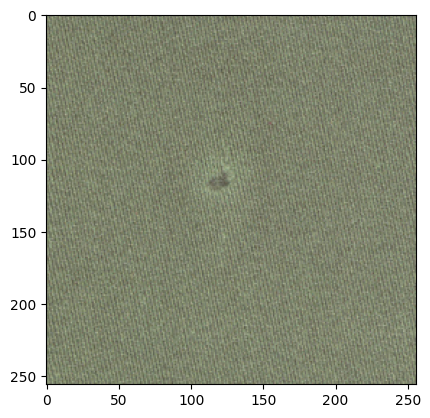

In [22]:
plt.imshow(image)

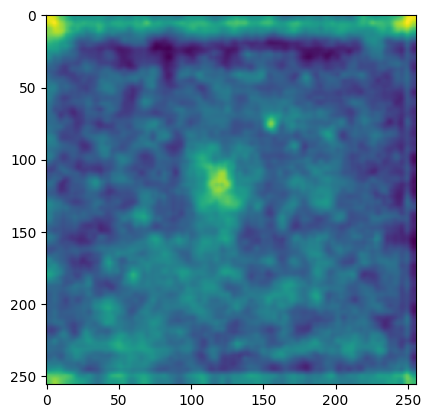

In [23]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

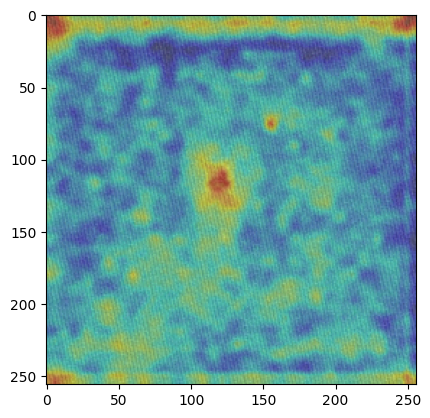

In [24]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

In [25]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(-0.2188) tensor(True)


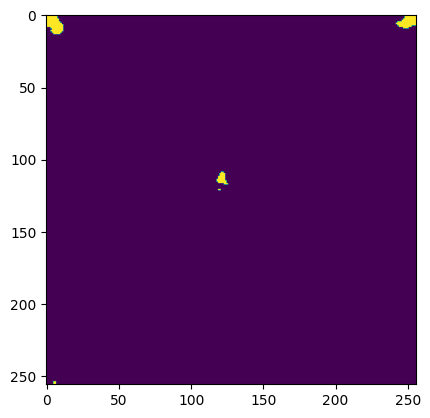

In [26]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

In [27]:
wandb.finish()

epoch,▁▁▂▂▄▄▅▅▇▇█
image_AUROC,▁▁▁▁▁▁
pixel_AUROC,▅█▇▄▂▁
train_loss_epoch,█▅▃▂▁
trainer/global_step,▁▁▃▃▄▄▆▆███
epoch,5
image_AUROC,1.0
pixel_AUROC,0.83157
train_loss_epoch,55362.69922
trainer/global_step,20


#Loading model from previous trainings

In [41]:
from pathlib import Path
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from anomalib.models.fastflow.lightning_model import Fastflow
from anomalib.data import InferenceDataset
from torch.utils.data import DataLoader
from anomalib.post_processing import superimpose_anomaly_map
from anomalib.pre_processing.transforms import Denormalize

# Set up the path to the saved weights
saved_weights_path = "/content/checkpoints/best-model-v1.ckpt"

# Initialize the model with the same configuration as used during training
model = Fastflow(input_size=(256, 256), backbone="resnet18", flow_steps=8)

# Load the saved weights
checkpoint = torch.load(saved_weights_path, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"])

# Initialize the WandB logger (use the same project name and entity if needed)
wandb_logger = WandbLogger(project="FastFlow-Anomaly-Detection", entity="kaustubhkapare")

# Initialize Trainer
trainer = Trainer(
    callbacks=[],
    accelerator="auto",
    devices=1,
    logger=wandb_logger
)

# Make sure the model is in evaluation mode
model.eval()

# Prepare your inference dataset and dataloader
inference_dataset = InferenceDataset(path=dataset_root / "Fabric20.jpg", image_size=(256, 256))
inference_dataloader = DataLoader(dataset=inference_dataset)

# Perform inference
predictions = trainer.predict(model=model, dataloaders=inference_dataloader)[0]

# Extract and process predictions
print(predictions.keys())
print(
    f'Image Shape: {predictions["image"].shape},\n'
    f'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    f'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

<ipython-input-41-03c0f6d286df>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_weights_path, map_location="cpu")
/usr/local/lib/python3.10/d

Predicting: 0it [00:00, ?it/s]

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])
Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: torch.Size([1, 1, 256, 256]), 
Predicted Mask Shape: torch.Size([1, 1, 256, 256])


Image Shape: (256, 256, 3)
 Min Pixel: 60 
 Max Pixel: 187


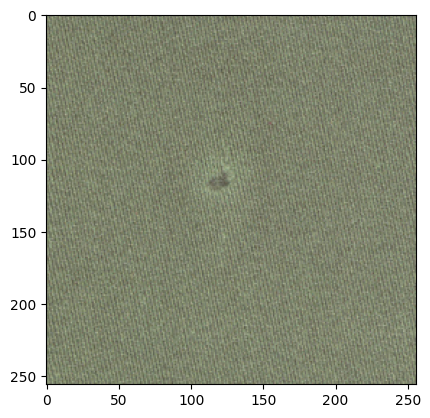

In [42]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

plt.imshow(image)


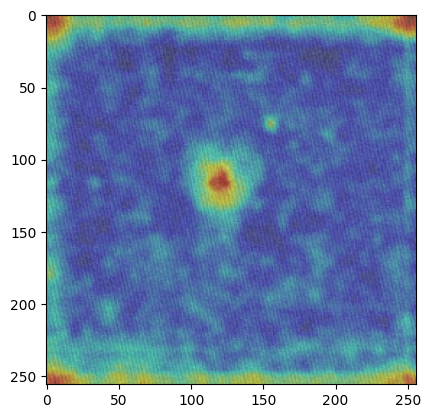

In [43]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

tensor(-0.2252) tensor(True)


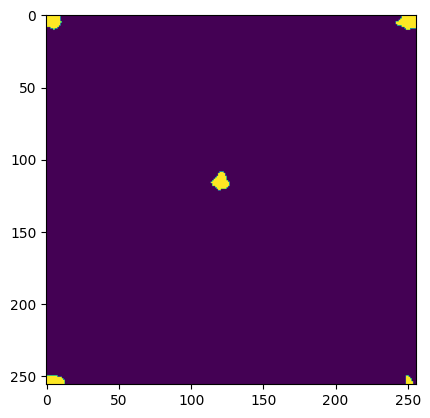

In [44]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

In [45]:
# Finish WandB
wandb.finish()

# Loading A previously trained model without Wandb as it is not required to load the previous model

<ipython-input-33-7a4648578e58>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_weights_path, map_location="cpu")
INFO:pytorch_lightning.util

Predicting: 0it [00:00, ?it/s]

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])
Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: torch.Size([1, 1, 256, 256]), 
Predicted Mask Shape: torch.Size([1, 1, 256, 256])
Image Shape: (256, 256, 3)
 Min Pixel: 60 
 Max Pixel: 187


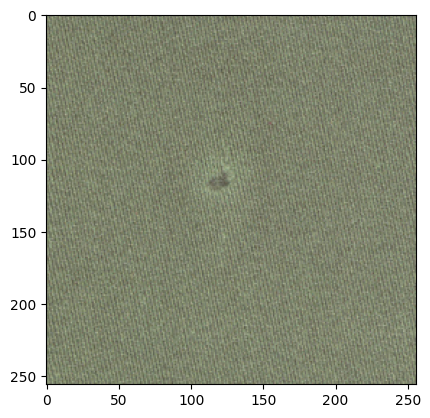

In [33]:
from pathlib import Path
import torch
from pytorch_lightning import Trainer
from anomalib.models.fastflow.lightning_model import Fastflow
from anomalib.data import InferenceDataset
from torch.utils.data import DataLoader
from anomalib.post_processing import superimpose_anomaly_map
from anomalib.pre_processing.transforms import Denormalize
import matplotlib.pyplot as plt

# Set up the path to the saved weights
saved_weights_path = "/content/drive/MyDrive/Task4/epoch=0-step=4-v1.ckpt"

# Initialize the model with the same configuration as used during training
model = Fastflow(input_size=(256, 256), backbone="resnet18", flow_steps=8)

# Load the saved weights
checkpoint = torch.load(saved_weights_path, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"])

# Initialize Trainer without the WandB logger
trainer = Trainer(
    callbacks=[],
    accelerator="auto",
    devices=1
)

# Make sure the model is in evaluation mode
model.eval()

# Prepare your inference dataset and dataloader
inference_dataset = InferenceDataset(path="/content/drive/MyDrive/Task4/Fabric20.jpg", image_size=(256, 256))
inference_dataloader = DataLoader(dataset=inference_dataset)

# Perform inference
predictions = trainer.predict(model=model, dataloaders=inference_dataloader)[0]

# Extract and process predictions
print(predictions.keys())
print(
    f'Image Shape: {predictions["image"].shape},\n'
    f'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    f'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

# Further processing of predictions
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

plt.imshow(image)

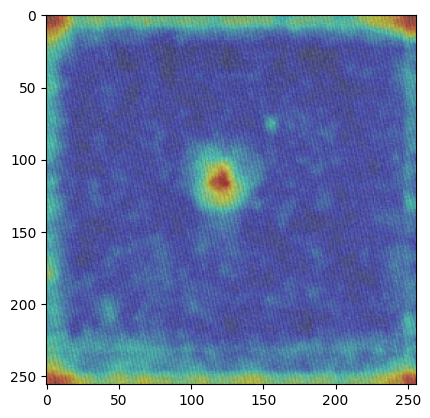

In [34]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

tensor(-0.2318) tensor(True)


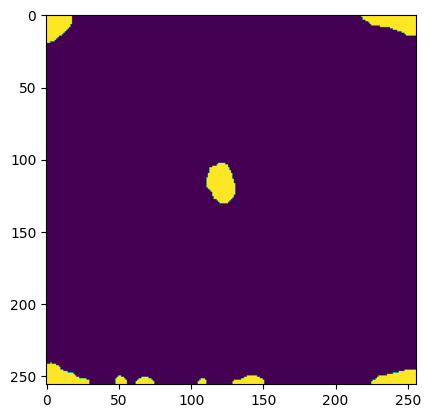

In [35]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)